# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [5]:
rect_start = None
rect_end = None
drawing = False

In [6]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [7]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [6]:
coord = interactive_bbox_selection("test_image.jpg")

Coordinates: [142, 133, 3445, 5973]


### Segment image based on rectangle coordinates


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\test_image.jpg: 640x640 1 0, 4251.6ms
Speed: 7.5ms preprocess, 4251.6ms inference, 80.9ms postprocess per image at shape (1, 3, 640, 640)


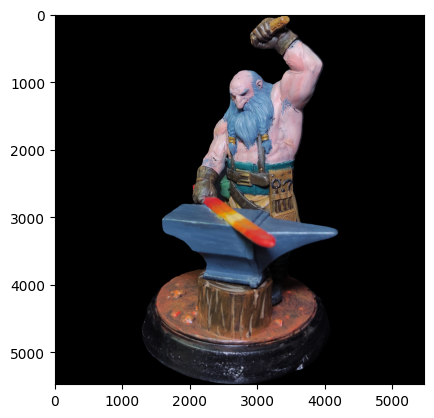

In [9]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [8]:
def segmenting_image(coordinates, model, source):
    results = model(source,
                    device="cuda",
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

Coordinates: [192, 108, 938, 1670]


image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
image 1/1 c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\frames\frame_0073.png: 640x640 1 0, 2089.4ms
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)
Speed: 284.4ms preprocess, 2089.4ms inference, 166.3ms postprocess per image at shape (1, 3, 640, 640)


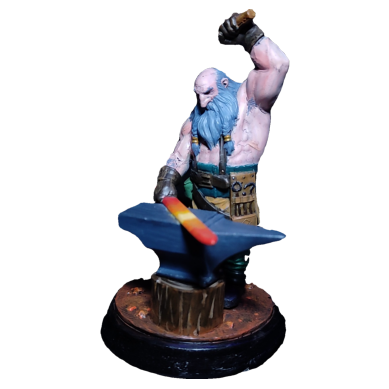

In [9]:
from ultralytics import SAM
%matplotlib inline

rect_start = None
rect_end = None
drawing = False

source = "frames/frame_0073.png"
model = SAM("models/sam_l.pt")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source)

## 3D reconstruction from videos

### Extract segmented frames from Video

In [1]:
import torch
import numpy as np

# Segment in every frame
def segmenting_image(coordinates, model, source):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = model(source,
                    device=device,
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)

            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

            res = cv2.bitwise_and(img, img, mask=b_mask)
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = res[y_min:y_max, x_min:x_max]

            return cropped_image

In [2]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_interval=30, coordinates = None, model = None):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0
    
    # Get rotation information
    rotation = int(cap.get(cv2.CAP_PROP_ORIENTATION_META))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Apply rotation correction based on metadata
        if rotation == 90:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        elif rotation == 180:
            frame = cv2.rotate(frame, cv2.ROTATE_180)
        elif rotation == 270:
            frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        # Save frame
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.png")

            #cv2.imwrite(frame_filename, frame)
            #frame = segmenting_image(coordinates, model, frame_filename)

            cv2.imwrite(frame_filename, frame)

            print(f"Extracted {extracted_count} image(s)")
            
            extracted_count += 1
        
        frame_count += 1 
    print(f"---- Image Extraction succeeded ----")
    cap.release()

In [3]:
from ultralytics import SAM

#model = SAM("models/sam_l.pt")
#coordinates = [159, 110, 941, 1644]

extract_frames("test_video.mp4", "frames", 30)

Extracted 0 image(s)
Extracted 1 image(s)
Extracted 2 image(s)
Extracted 3 image(s)
Extracted 4 image(s)
Extracted 5 image(s)
Extracted 6 image(s)
Extracted 7 image(s)
Extracted 8 image(s)
Extracted 9 image(s)
Extracted 10 image(s)
Extracted 11 image(s)
Extracted 12 image(s)
Extracted 13 image(s)
Extracted 14 image(s)
Extracted 15 image(s)
Extracted 16 image(s)
Extracted 17 image(s)
Extracted 18 image(s)
Extracted 19 image(s)
Extracted 20 image(s)
Extracted 21 image(s)
Extracted 22 image(s)
Extracted 23 image(s)
Extracted 24 image(s)
Extracted 25 image(s)
Extracted 26 image(s)
Extracted 27 image(s)
Extracted 28 image(s)
Extracted 29 image(s)
Extracted 30 image(s)
Extracted 31 image(s)
---- Image Extraction succeeded ----


### Building 3D models from 2D images

#### Libraries import

In [1]:
import matplotlib
matplotlib.use("TkAgg")
from matplotlib import pyplot as plt
from PIL import Image
import torch
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Getting Model

In [2]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### Loading and resizing the image

In [3]:
image = Image.open("frames/frame_0001.png")

new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32

new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

#### Preparing the image for the model

In [4]:
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

#### Getting the prediction

In [5]:
with torch.no_grad():
    outputs = model(**inputs)
    
predicted_depth = feature_extractor.post_process_depth_estimation(
    outputs, target_sizes=[(image.height, image.width)],
)

#### Post-processing

In [6]:
depth = predicted_depth[0]["predicted_depth"]
depth = (depth - depth.min()) / (depth.max() - depth.min())
depth = depth * 255.
depth = depth.detach().cpu().numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft = False, labelbottom=False)
ax[1].imshow(depth, cmap="plasma")
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)

#### Preparing the depth image for open3d

In [7]:
width, height = image.size

depth_image = (depth * 255 / np.max(depth)).astype('uint8')
image = np.array(image)

depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,
                                                                depth_o3d,
                                                                convert_rgb_to_intensity=False)

#### Creating a camera

In [8]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width/2, height/2)

#### Creating o3d point cloud

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

#### Post-processing the 3D Point Cloud

In [14]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors = 20, std_ratio = 2.0)
pcd = pcd.select_by_index(ind)

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd])

#### Surface reconstruction

In [15]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center = (0, 0, 0))

o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

#### 3D Mesh Export

In [28]:
o3d.io.write_triangle_mesh("test.obj", mesh)

[Open3D WARNING] Write OBJ can not include triangle normals.


True

## Pre-painting - coloring sketch

### Converting image to sketch

In [11]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ss = imageio.imread(img)
C:\Users\gusta\AppData\Local\Temp\ipykernel_11676\2039978225.py:31: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)


True

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

Text(value='', description='Text:', placeholder='Type something')

ColorPicker(value='#ff0000', description='Pick a color')

Button(description='Submit', icon='check', style=ButtonStyle(), tooltip='Click to submit text and color')

Button(description='Clear', icon='delete', style=ButtonStyle(), tooltip='Click to submit text and color')

Added: Ground with color #452e1c
Added: Shoe with color #97511c
Added: Guitar body with color #db7f39
Added: Guitar cord with color #747372
Added: Guitar horn with color #ffda8a
Added: Guitar tuner with color #eba000
Added: Socks with color #e81717
Added: Shoe detail with color #b67d02
Added: Shoe detail stripe with color #5c3db3
Added: Socks pearl with color #ffddc7
Added: Cloth bellow pearl with color #4d61ff
Added: Shin guard with color #58595a
Added: Shin guard detail with color #f4b734
Added: Pants with color #fbe7bc
Added: Pant stripes with color #369b8a
Added: Knife sheath with color #9058f9
Added: Waist stripes with color #000000
Added: Waist stripe tips with color #6f38d6
Added: Knife cord with color #cea969
Added: Knife metal with color #8b8479
Added: Knife gripper with color #69aae8
Added: Belt metal with color #788591
Added: Gloves with color #202122
Added: Cape with color #af2843
Added: Shirt with color #de1721
Added: Bodice with color #77181d
Added: Jacket with color #185

In [13]:
print(text_color_dict)

{}


### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)